In [3]:
# from utils import PyRepEnvironment
from pyrep import PyRep
from pyrep.objects import Dummy
from pyrep.robots.robot_component import RobotComponent
from utils import StarkitRobot
from basic_walk.utils import BaseAgent
import sys
import time
import gym
from gym import spaces
from gym.utils import seeding
from pyrep.backend import sim, simConst

import matplotlib.pyplot as plt
import numpy as np

In [7]:
class VelocityAliveReward(object):
    def __init__(self, start_position, target_position, dt, alpha=1.25, count_steps=50, max_step=600, goal_threshold=0.05):
        self._start_position = start_position
        self._target_position = target_position
        self._dt = dt
        self._alpha = alpha
        self._count_steps = count_steps
        self._max_step = max_step
        self._goal_threshold = goal_threshold
        self._target_velocity = np.array([1, 0])
        self.reset()

    def _get_fall_prob(self):
        return (1 - self._current_quat[3]) / 2
    
    def _get_fall_reward(self):
        fall_prob = self._get_fall_prob()
        fall_reward = 0
        if fall_prob > 0.3:
            fall_reward = (0.3 - fall_prob) / 7 * 10
        return fall_reward
    
    def _get_velocity_reward(self):
        current_velocity = (self._positions_queue[-1] - self._positions_queue[0])[:2] / (self._dt * len(self._positions_queue))
        velocity_reward = current_velocity @ self._target_velocity
        velocity_reward = self._alpha * velocity_reward
        return velocity_reward

    def _done(self):
        fall_prob = self._get_fall_prob
        if fall_prob > 0.5:
            return True
        return False
    
    def reset(self):
        self._positions_queue = [self._start_position, ]
        self._current_quat = None
        self._current_step_idx = 0

    def compute_reward(self, current_position, current_quat):
        self._positions_queue.append(current_position)
        if len(self._positions_queue) > self._count_steps:
            self._positions_queue.pop(0)

        self._current_quat = current_quat
        r = self._get_fall_reward() + self._get_velocity_reward()
#         done = self._done()
        done = False
        return r, done

In [8]:
class SurrogatPyRepEnvironment(gym.Env):
    def __init__(
         self,
         scene: str,
         dt: float = 0.02,
         headless_mode: bool = False
    ):
        self.seed()
        self._pr = PyRep()
        self._pr.launch(scene, headless=headless_mode)
        if not headless_mode:
            self._clear_gui()
            
        self._pr.set_simulation_timestep(dt)
        self._pr.start()
        self._robot = StarkitRobot()
        self._create_goal()
        self._init_spaces()
#         self._reward_calc = DistanceFallReward(self._robot_position(), self._goal.get_position())
        self._reward_calc = VelocityAliveReward(self._robot_position(), self._goal.get_position(), dt=dt, count_steps=30)
        
    def __del__(self):
        self.close()

    def _init_spaces(self):
        cyclics, join_intervals = self._robot.get_joint_intervals()
        for i, cyclic in enumerate(cyclics):
            if cyclic:
                join_intervals[i] = [-np.pi, np.pi]
        action_intervals = np.array(join_intervals)
        self.action_space = spaces.Box(low=action_intervals.T[0], high=action_intervals.T[1], dtype=np.float32)
        
        quaternion_limits = np.ones((4, 2)) * np.array([-1, 1])
        state_intervals = np.vstack([action_intervals, quaternion_limits])
        self.observation_space = spaces.Box(low=state_intervals.T[0], high=state_intervals.T[1], dtype=np.float32)

    def _robot_position(self):
        return self._robot.imu.get_position()
    
    def _robot_quaternion(self):
        return self._robot.imu.get_quaternion()

    def _create_goal(self):
        self._goal = Dummy.create(size=0.1)
        self._goal.set_renderable(True)
        self._goal.set_name('Goal')
        self._goal.set_position(self._robot_position() * np.array([-1, 1, 1]))

    @staticmethod
    def _clear_gui():
        sim.simSetBoolParameter(simConst.sim_boolparam_browser_visible, False)
        sim.simSetBoolParameter(simConst.sim_boolparam_hierarchy_visible, False)
        sim.simSetBoolParameter(simConst.sim_boolparam_console_visible, False)
    
    def _get_state(self):
        joint_positions = self._robot.get_joint_positions()
        imu_quat = self._robot_quaternion()
        state = np.hstack([joint_positions, imu_quat])
        return state

    def step(self, action):
        self._robot.set_joint_target_positions(action)
        self._pr.step()
        state = self._get_state()
        r, done = self._reward_calc.compute_reward(self._robot_position(), self._robot_quaternion())
        
        return state, r, done

    def reset(self):
        self._pr.set_configuration_tree(self._robot.initial_configuration)
        self._reward_calc.reset()
        self._pr.step()

        return self._get_state()

    def close(self):
        self._pr.stop()
        self._pr.shutdown()

    def seed(self, seed: int = None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def render(self, mode: str = 'human'):
        print('Not implemented yet')

# Base Agent

## Ходьба

In [9]:
times = []
rewards = []

with SurrogatPyRepEnvironment('scenes/basic_scene.ttt') as env:
    for i in range(1):
        agent = BaseAgent()

        state = env.reset()
        for _ in range(600):
            times.append(time.time())
            action = agent.act(state)
            state, r, done = env.step(action)
            rewards.append(r)
            if done:
                break

## Анализ

In [10]:
times[1] - times[0]

0.023367643356323242

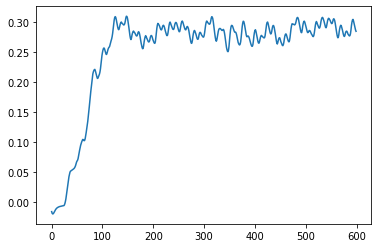

In [11]:
plt.plot(rewards)

## Обучение нового агента

In [12]:
from tqc import structures, DEVICE
from tqc.trainer import Trainer
from tqc.structures import Actor, Critic, RescaleAction
from tqc.functions import eval_policy
from tqdm import tqdm
import copy

In [15]:
def fill_replay_buffer(env, replay_buffer, goal_len=10000, episode_length=600):
    agent = BaseAgent()
    state, done = env.reset(), False
    episode_timesteps = 0
    
    for _ in range(goal_len):
        episode_timesteps += 1
        action = agent.act(state)
        action = np.array(action)
        action /= np.pi
        next_state, reward, done = env.step(action)
        replay_buffer.add(state, action, next_state, reward, done)
        state = next_state
        
        if done or episode_timesteps >= episode_length:
            state, done = env.reset(), False
            episode_timesteps = 0
    
    return replay_buffer

In [16]:
def train(
    max_timesteps=1e6,
    seed=0,
    n_quantiles=25,
    top_quantiles_to_drop_per_net=2,
    n_nets=5,
    batch_size=256,
    discount=0.99,
    tau=0.005,
    episode_length=600
):
    with SurrogatPyRepEnvironment('scenes/basic_scene.ttt', headless_mode=True) as env:
        env = RescaleAction(env, -1., 1.)

        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        replay_buffer = structures.ReplayBuffer(state_dim, action_dim)
        actor = Actor(state_dim, action_dim).to(DEVICE)
        critic = Critic(state_dim, action_dim, n_quantiles, n_nets).to(DEVICE)
        critic_target = copy.deepcopy(critic)

        top_quantiles_to_drop = top_quantiles_to_drop_per_net * n_nets

        trainer = Trainer(actor=actor,
                          critic=critic,
                          critic_target=critic_target,
                          top_quantiles_to_drop=top_quantiles_to_drop,
                          discount=discount,
                          tau=tau,
                          target_entropy=-np.prod(env.action_space.shape).item())
    
        replay_buffer = fill_replay_buffer(env, replay_buffer)
        
        evaluations = []
        state, done = env.reset(), False
        episode_return = 0
        episode_timesteps = 0
        episode_num = 0

        actor.train()
        for t in tqdm(range(int(max_timesteps))):
            episode_timesteps += 1
            action = actor.select_action(state)
            next_state, reward, done, = env.step(action)

            replay_buffer.add(state, action, next_state, reward, done)

            state = next_state
            episode_return += reward

            trainer.train(replay_buffer, batch_size)

            if done or episode_timesteps >= episode_length:
                # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
                print(f"Total T: {t + 1} Episode Num: {episode_num + 1} Episode T: {episode_timesteps} Reward: {episode_return:.3f}")
                # Reset environment
                state, done = env.reset(), False

                episode_return = 0
                episode_timesteps = 0
                episode_num += 1
        return actor

In [47]:
with SurrogatPyRepEnvironment('scenes/basic_scene.ttt', headless_mode=True) as env:
    env = RescaleAction(env, -1., 1.)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    replay_buffer = structures.ReplayBuffer(state_dim, action_dim)
    
    replay_buffer = fill_replay_buffer(env, replay_buffer)

Exception ignored in: <bound method SurrogatPyRepEnvironment.__del__ of <__main__.SurrogatPyRepEnvironment object at 0x7faf199b9128>>
Traceback (most recent call last):
  File "<ipython-input-10-a73dcf59bc2f>", line 23, in __del__
  File "<ipython-input-10-a73dcf59bc2f>", line 76, in close
  File "/home/alex/projects/tqc_pytorch/src/pyrep/pyrep/pyrep.py", line 184, in stop
    'CoppeliaSim has not been launched. Call launch first.')
pyrep.errors.PyRepError: CoppeliaSim has not been launched. Call launch first.


RuntimeError: The call failed on the V-REP side. Return value: -1

In [ ]:
actor = train()

  0%|          | 604/1000000 [00:25<11:27:22, 24.23it/s]

Total T: 600 Episode Num: 1 Episode T: 600 Reward: 9.005


  0%|          | 1204/1000000 [00:50<11:44:07, 23.64it/s]

Total T: 1200 Episode Num: 2 Episode T: 600 Reward: -83.709


  0%|          | 1804/1000000 [01:16<11:36:54, 23.87it/s]

Total T: 1800 Episode Num: 3 Episode T: 600 Reward: -73.297


  0%|          | 2405/1000000 [01:43<11:51:19, 23.37it/s]

Total T: 2400 Episode Num: 4 Episode T: 600 Reward: -120.243


  0%|          | 3002/1000000 [02:10<11:54:36, 23.25it/s]

Total T: 3000 Episode Num: 5 Episode T: 600 Reward: -95.253


  0%|          | 3602/1000000 [02:36<11:49:44, 23.40it/s]

Total T: 3600 Episode Num: 6 Episode T: 600 Reward: -131.627


  0%|          | 4202/1000000 [03:02<11:48:06, 23.44it/s]

Total T: 4200 Episode Num: 7 Episode T: 600 Reward: -126.832


  0%|          | 4805/1000000 [03:28<11:33:42, 23.91it/s]

Total T: 4800 Episode Num: 8 Episode T: 600 Reward: -89.238


  1%|          | 5405/1000000 [03:56<11:51:54, 23.28it/s]

Total T: 5400 Episode Num: 9 Episode T: 600 Reward: -162.337


  1%|          | 6002/1000000 [04:22<12:53:18, 21.42it/s]

Total T: 6000 Episode Num: 10 Episode T: 600 Reward: -163.073


  1%|          | 6602/1000000 [04:49<12:37:33, 21.86it/s]

Total T: 6600 Episode Num: 11 Episode T: 600 Reward: -164.704


  1%|          | 7204/1000000 [05:18<11:48:01, 23.37it/s]

Total T: 7200 Episode Num: 12 Episode T: 600 Reward: -203.084


  1%|          | 7801/1000000 [05:47<16:16:34, 16.93it/s]

Total T: 7800 Episode Num: 13 Episode T: 600 Reward: -335.043


  1%|          | 8402/1000000 [06:15<12:23:11, 22.24it/s]

Total T: 8400 Episode Num: 14 Episode T: 600 Reward: -84.653


  1%|          | 8546/1000000 [06:22<13:21:55, 20.61it/s]